# Time Series Clustering (Cortisol)

Clustering is something I've always been aware of, but not something I've worked with hands-on very often. Algorithms like K-means and agglomerative clustering are easy to pick up quickly, because their visualizations are very straight-forward. Considering their simplicity, they are quite powerful techniques, especially with well-defined data with a reasonable number of dimensions. It also helps that commonly-used distance measures are easy to conceptualize (e.g. Euclidean). The picture gets a little more complicated with high dimmensional data (see <a href="https://en.wikipedia.org/wiki/Curse_of_dimensionality" target="_blank">curse of dimensionality</a>) or time series data. 

Cortisol response patterns are of particular interest to health psychologists. My <a href="https://www.ncbi.nlm.nih.gov/pubmed/30513499" target="_blank">paper in Psychoneuroendocrinology</a> explains why in some depth. The general idea is that repeated stress over time may cause alterations in the brain and body which regulate cortisol responses. These alterations may manifest as maladaptive patterns of cortisol resposnes to acute stress. It's not uncommon for researchers to examine cortisol response trajectories--via baseline-to-peak, area-under-the-curve (AUC), or slope measures--as either predictors or dependent variables in relation to other psychological or social phenomena. However, characterizing and analyzing entire response curves remains a challenge. Here I'll see if I can characterize some response profiles using time series clustering of cortisol response data from the <a href="http://midus.wisc.edu/" target="_blank">Midlife in the United States (MIDUS)</a> biomarker project (refresher). The biomarker project collected cortisol before, during, and after a challenge protocol (see below). The dataset is open to all, but you'll have to register to access data. 

While I'll explain the process and my choices in broad strokes, I will not be providing a comprehensive description of all the methods used. See below for some very useful links for those looking for more information and intuition.

## Similarity Measure and Clustering Algorithm

While Euclidean distance is often used in clustering, it may not be the best choice if measurements vary in time or speed. Although this probably isn't much of a concern with a time series of only 5 points like I have here, for practice I'll still use a measure that offers a little more flexibility. Instead I'll use Dynamic Time Warping to produce the similarity measure. Briefly, when comparing two time series this approach is not constrained to comparing _only_ identitcal indices. This allows the similarity metric to take into account sequences that are similar even if they are offset. Again, see links below for comprehensive explanations.

Although k-means is commonly-used clustering algorithm for static data, it may not be the best choice for time-series data for a variety of reasons (see Aghabozorgi et al article below for more details). Instead, I'll use hierarchical agglomerative clustering.


## Helpful links!

_Dynamic Time Warping_

https://www.youtube.com/watch?v=_K1OsqCicBY

https://en.wikipedia.org/wiki/Dynamic_time_warping

https://pypi.org/project/fastdtw/

_Hierarchical Agglomerative Clustering_

https://en.wikipedia.org/wiki/Hierarchical_clustering

https://towardsdatascience.com/understanding-the-concept-of-hierarchical-clustering-technique-c6e8243758ec

https://docs.scipy.org/doc/scipy/reference/cluster.hierarchy.html

Cluster linkages:

https://www.youtube.com/watch?v=VMyXc3SiEqs&t=438s

_Time-series clustering – A decade review (Saeed Aghabozorgi, Ali Seyed Shirkhorshidi, Teh Ying Wah):_

https://www.sciencedirect.com/science/article/abs/pii/S0306437915000733

## MIDUS Details

http://midus.wisc.edu/index.php

Since 1995 the MIDUS study has been funded by the following:
John D. and Catherine T. MacArthur Foundation Research Network National Institute on Aging (P01-AG020166)
National institute on Aging (U19- AG051426)
For Biomarker Data:
Biomarker data collection was further supported by the NIH National Center for Advancing Translational Sciences (NCATS) Clinical and Translational Science Award (CTSA) program as follows: UL1TR001409 (Georgetown),
UL1TR001881 (UCLA)
1UL1RR025011 (UW)

__Challenge Protocol (from MIDUS documentation):__

"The samples were collected at five time points: 1) Pre-protocol (prior to attaching the ECG leads and other monitors); 2) Baseline (NEW): immediately before the Seated Baseline physiological recording begins; 3) Post-Cognitive Stress: after completing both Cognitive Stress Tasks and their corresponding Recovery periods; 4) Standing: immediately after the orthostatic challenge; 5) Recovery: 30 minutes after the orthostatic challenge."

# Clustering in Python

First I'll get the data and libraries set up. Again, MIDUS data is open access, but you will have to register to access it yourself. 

In [1]:
import os
import itertools
import numpy as np
import pandas as pd
from fastdtw import fastdtw as fdtw
from scipy.stats import zscore
from scipy.spatial.distance import euclidean, squareform, pdist
from scipy.cluster.hierarchy import single, complete, average, fcluster
from scipy.cluster import hierarchy
import matplotlib.pyplot as plt

In [2]:
dfpath = '/Users/alex/Documents/alexdatasci/data_files/' + \
'MIDUS_R/biomarker/DS0001/36901-0001-Data.dta'

varnames = ['MRID', 'RA4BSCL1', 'RA4BSCL2', 
            'RA4BSCL3', 'RA4BSCL4', 'RA4BSCL5']

df = pd.read_stata(dfpath, columns=varnames)

# Drop MISSING, convert to float
df.replace(['MISSING', 'INAPP', "DON'T KNOW"], np.nan, inplace=True)
df.iloc[:,1:] = df.iloc[:,1:].astype('float')
df = df.dropna().reset_index(drop=True)
df.head()

,MRID,RA4BSCL1,RA4BSCL2,RA4BSCL3,RA4BSCL4,RA4BSCL5
0,30024,30.634001,25.014000,20.698999,20.194000,19.372999
1,30052,16.679001,14.532000,27.393000,37.327999,33.770000
2,30059,8.512000,10.112000,16.006001,13.795000,16.174000
3,30092,15.564000,26.551001,22.740999,17.774000,18.993999
4,30113,17.268000,20.341999,13.606000,14.132000,13.606000


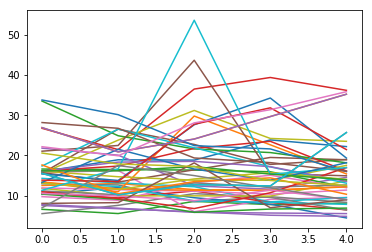

In [3]:
# Plot some responses
rand_50 = np.random.randint(0,df.shape[0]-1,50)

for i in rand_50:
    plt.plot(range(5), df.iloc[i,1:])
plt.show()

It's clear that there's quite a lot of heterogeneity in responses, which highlights the difficulty in categorizing paterns. I'll standardize the time series (within individual) since I'm more interested in general shapes of response curves at this stage and clustering algorithms tend to work better with scaled data.

In [4]:
Y = zscore(df.iloc[:,1:].to_numpy(),axis=1)
XY = np.array([list(zip(range(5), i)) for i in Y])

The hierarchical algorithm requires a distance\* matrix to work, so I'll define a little function to retrieve all possible pairwise DTW values. I'll use the fastdtw module to get the values. This module closely approximates DTW while decreasing the time complexity required.

\* I should note that DTW is a similarity measure similar to distance, but not a proper distance measure.

In [5]:
def get_upper(x):
    ijs = list(itertools.combinations(range(x.shape[0]),2))
    return np.array([fdtw(x[i[0],:],
                          x[i[1],:],
                          dist=euclidean)[0] for i in ijs])

Now I'll get the matrix values and complete the clustering using single, complete, and average linkages. Even with fastdtw, this takes a bit of time.

In [6]:
Z = get_upper(XY)

In [7]:
link_m = single(Z)
link_m_c = complete(Z)
link_m_a = average(Z)

Let's take a look at the dendrogram for each type of linkage to get a sense of the clusters.

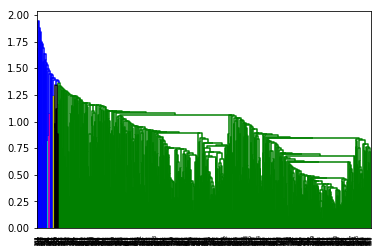

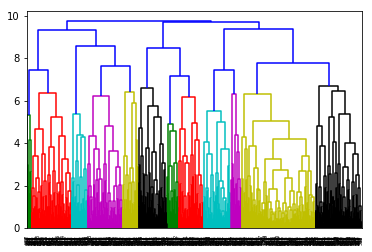

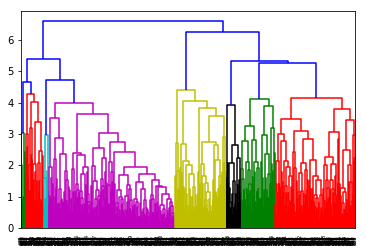

In [8]:
dn_m = hierarchy.dendrogram(link_m)
plt.show()
dn_m_c = hierarchy.dendrogram(link_m_c)
plt.show()
dn_m_a = hierarchy.dendrogram(link_m_a)
plt.show()

With so many observations, these dendrograms are pretty ugly. Still, we can see how the different linkages produce different clusters. I'll explore the complete linkage clusters in greater detail. Next I'll write a helper function to show the median response curves by cluster. Then, I'll take a look at how the these curves differ by number of clusters (based on where the tree is cut).

In [9]:
def show_med_curves(y, clusters, ax=None, **kwargs):
    ax=ax
    uniques = np.unique(clusters)
    ns = pd.Series(clusters).value_counts(sort=False)
    for c in uniques:
        mask = [i for i in range(y.shape[0]) if clusters[i]==c]
        ax.plot(range(y.shape[1]),
                np.median(y[mask],axis=0))
    ax.legend(['Cluster = ' + str(i) + ' N=' + str(ns[i]) for i in uniques],
              loc='center left', bbox_to_anchor=(1, 0.5))

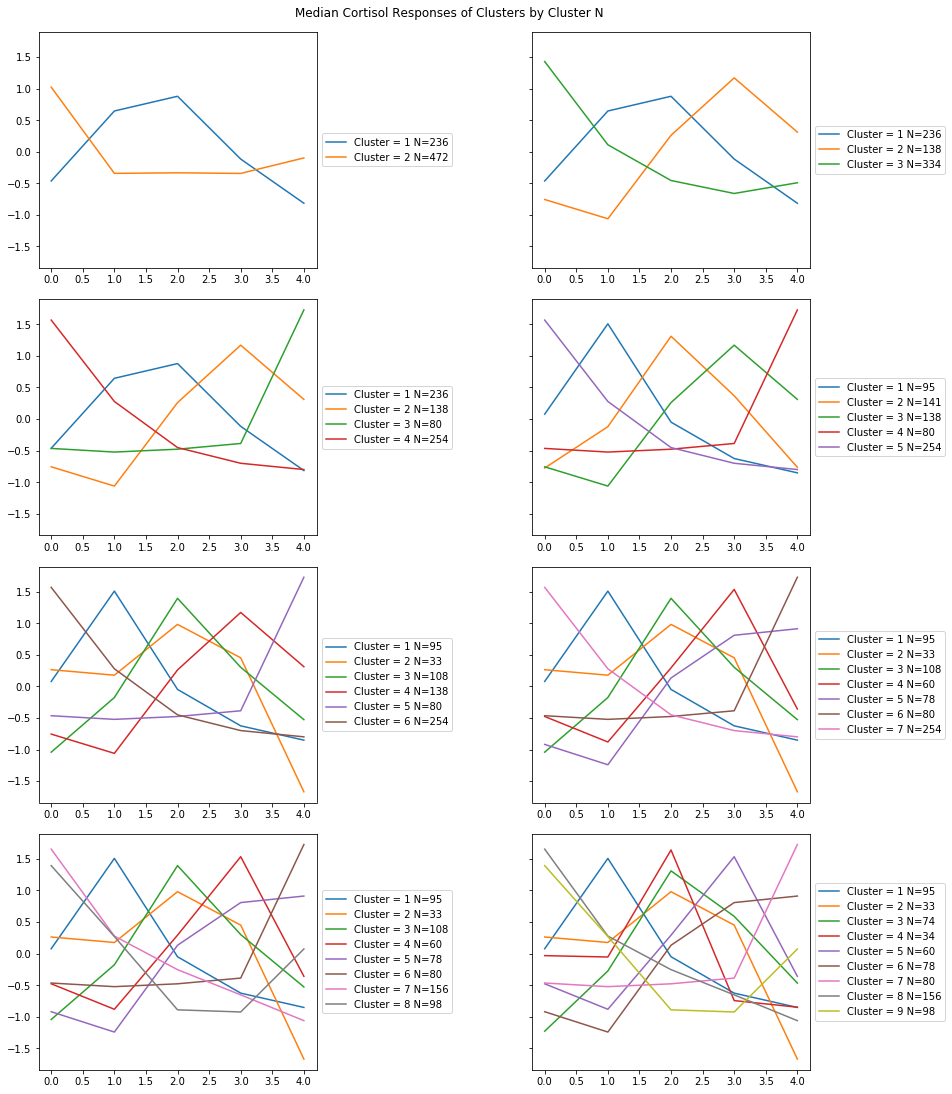

In [10]:
ar = 1
fig, ax1 = plt.subplots(4,2,figsize=(15,15),sharey=True)

show_med_curves(Y, fcluster(link_m_c, 2, criterion='maxclust'), ax=ax1[0,0])
ax1[0,0].set_aspect(ar)
show_med_curves(Y, fcluster(link_m_c, 3, criterion='maxclust'), ax=ax1[0,1])
ax1[0,1].set_aspect(ar)

show_med_curves(Y, fcluster(link_m_c, 4, criterion='maxclust'), ax=ax1[1,0])
ax1[1,0].set_aspect(ar)
show_med_curves(Y, fcluster(link_m_c, 5, criterion='maxclust'), ax=ax1[1,1])
ax1[1,1].set_aspect(ar)

show_med_curves(Y, fcluster(link_m_c, 6, criterion='maxclust'), ax=ax1[2,0])
ax1[2,0].set_aspect(ar)
show_med_curves(Y, fcluster(link_m_c, 7, criterion='maxclust'), ax=ax1[2,1])
ax1[2,1].set_aspect(ar)

show_med_curves(Y, fcluster(link_m_c, 8, criterion='maxclust'), ax=ax1[3,0])
ax1[3,0].set_aspect(ar)
show_med_curves(Y, fcluster(link_m_c, 9, criterion='maxclust'), ax=ax1[3,1])
ax1[3,1].set_aspect(ar)

plt.tight_layout()
fig.suptitle("Median Cortisol Responses of Clusters by Cluster N",x=.5,y=1.01)
plt.show()

Visual inspection of these curves shows some interesting patterns, particularly the first 4 subplots. If you had to choose two types of curves to characterize all responses knowing absolutely nothing, you'd probably come up with something closely resembling the first subplot. At the highest level, responses are clustered into those that show a general increase followed by a decrease, and those that exhibit no response (but instead decrease initially then remain flat). At each subsequent level of the hierarchy, new curves appear with different peaks. This makes intuitive sense, and shows that in general cortisol responses are defined by when (or if) they peak in relation to the stressor.

Of course, determining the "right" number of clusters is a tricky, subjective exercise. Aside from just a visual inspection, there are techniques out there to help make more data-driven decisions (e.g. silhouette score). Still, even those techniques involve arbitrary decisions. This is, after all, an exploratory technique. Given the median curves shown above, I'd probably take a closer look at the utility of 2 or 5 clusters. To my eye, after four clusters additional curves appear to closely resemble existing patterns.

# Some Conclusions

The challenge protocol used with this study was not the most robust and is not commonly used in laboratory-based acute stress research. This is understandable given that cortisol reactivity was not the central aim of the project and they had to accomodate a large number of participants and reserach aims. Therefore, the responses we see here may not be all that representative of acute stress. Still, even with this moderate stressor we can see some distinct patterns emerging that make sense in the context of acute stress. If I were to speculate, I'd say that the cluster that shows a somewhat-exponential decrease in cortisol (e.g. cluster 4 in subplot 3) is probably indicative of those individuals who had higher levels of anticipatory stress (i.e. they came in pre-stressed). Subsequent peaks show individual differences in the timing of responses that could be due to a variety of factors, including how stressful they found each task of the protocol and underlying physiological differences. Regardless, the results of this analysis could serve as a valuable starting point for generating new hypotheses to test, which is one of the main objectives of clustering.

Again, this little project represents the very early stages of an exploratory process, and the utility of the resulting clusters is uncertain. Nevertheless, I think it's interesting and cool that this fairly easy unsupervised clustering algorithm yielded distinct, visually identifiable median response patterns. One could and probably should argue that this approach to time series clustering may not be the best approach for this particular problem. Using an algorithm where time indices are _not_ always explicitly matched may be problematic for comparing cortisol responses. Should you really consider responses of a similar shape but offset as members of a same cluster in this situation? I suppose it depends how you look at it. Point is, this was just a very quick and dirty clustering analysis and shouldn't be taken too seriously, at least not without interogating the results further and considering different clustering schemes. Still, it would be really cool if these clusters were predictive of some other measures of health or wellbeing. Maybe I'll take a look at some of the other variables in the MIDUS dataset later to see if this is the case (there are TONS of variables that could be of interest). But that's a project for another day.